### 1. Data downloading and exploration

In [1]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset = load_dataset("banking77")

train = dataset["train"]
test = dataset["test"]

print("Train size:", len(train))
print("Test size:", len(test))

Train size: 10003
Test size: 3080


In [3]:
df_train = train.to_pandas()
df_test = test.to_pandas()

df_train.head()

,text,label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11


In [4]:
print("Train info:")
print(df_train.info())

print("\nTest info:")
print(df_test.info())

print("\nSample labels:", df_train["label"].unique()[:10])
print("Min label:", df_train["label"].min())
print("Max label:", df_train["label"].max())

Train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10003 entries, 0 to 10002
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10003 non-null  object
 1   label   10003 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB
None

Test info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3080 entries, 0 to 3079
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3080 non-null   object
 1   label   3080 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 48.3+ KB
None

Sample labels: [11 13 32 17 34 46 36 12  4 14]
Min label: 0
Max label: 76


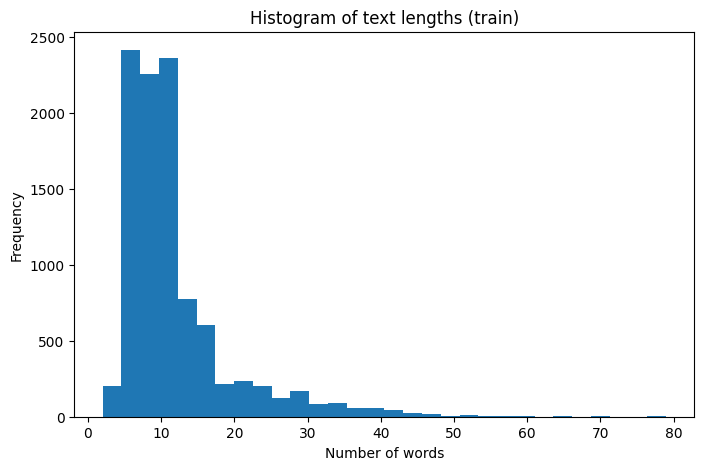

In [5]:
train_lengths = df_train["text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5))
plt.hist(train_lengths, bins=30)
plt.title("Histogram of text lengths (train)")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

/tmp/ipykernel_554288/1574729949.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_train["label"], palette="viridis")


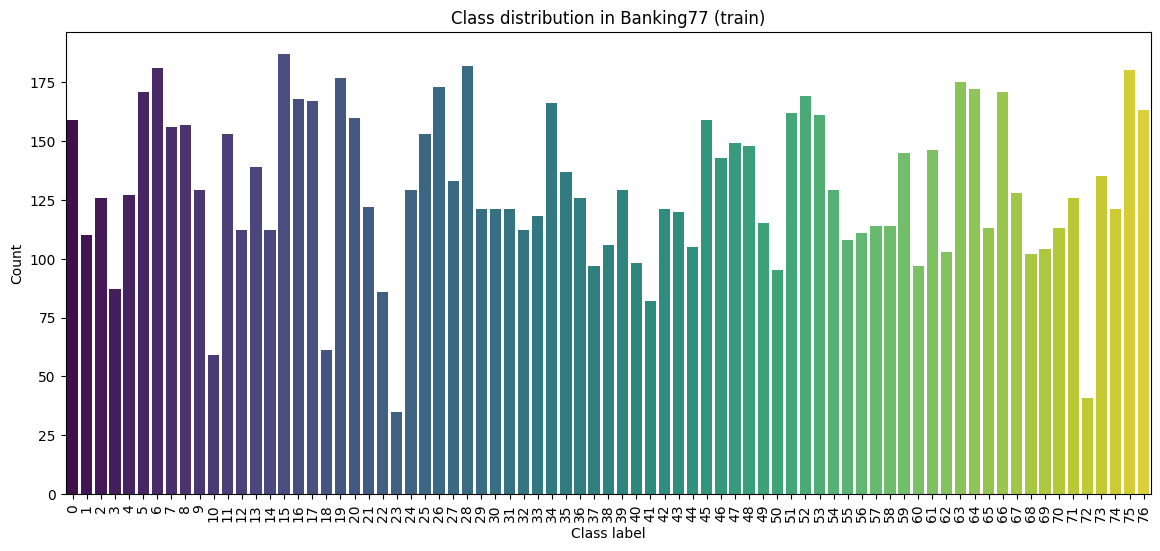

In [6]:
plt.figure(figsize=(14,6))
sns.countplot(x=df_train["label"], palette="viridis")
plt.title("Class distribution in Banking77 (train)")
plt.xlabel("Class label")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

In [7]:
print("Average text length:", train_lengths.mean())
print("Median text length:", train_lengths.median())
print("Max length:", train_lengths.max())
print("Min length:", train_lengths.min())

Average text length: 11.949415175447365
Median text length: 10.0
Max length: 79
Min length: 2


In [8]:
import numpy as np
from sentence_transformers import SentenceTransformer

texts_train = df_train["text"].to_numpy()
labels_train = df_train["label"].to_numpy()

embedder = SentenceTransformer("all-MiniLM-L6-v2")

emb_train = embedder.encode(texts_train, show_progress_bar=True, batch_size=64)
emb_train = np.asarray(emb_train)
emb_train.shape

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

(10003, 384)

In [9]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_predict

clf = LogisticRegressionCV(
    Cs=10,
    cv=5,
    max_iter=2000,
    multi_class="auto",
    class_weight="balanced",
    n_jobs=-1,
)

pred_probs = cross_val_predict(
    clf,
    emb_train,
    labels_train,
    cv=5,
    method="predict_proba",
    n_jobs=-1,
)
pred_probs.shape


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

(10003, 77)

In [15]:
from cleanlab.filter import find_label_issues

label_issue_indices = find_label_issues(
    labels=labels_train,
    pred_probs=pred_probs,
    return_indices_ranked_by="self_confidence",  # od najbardziej podejrzanych
)

print("Najbardziej podejrzane etykiety (top 20):")
print(label_issue_indices[:20])
print("Liczba podejrzanych etykiet:", len(label_issue_indices))

df_train.iloc[label_issue_indices[:20]][["text", "label"]]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Najbardziej podejrzane etykiety (top 20):
[  93 4428 1490 5653 1306 1675 1931 4974 7623 8726 6033 4792 8412 5643
 5623   79 1786 8555 1788 8036]
Liczba podejrzanych etykiet: 151


,text,label
93,WHAT IS THE SOLUTION OF THIS PROBLEM,11
4428,i am not a premium customer but i want a virtu...,29
1490,Can you tell me the status of my new card?,41
5653,"please help me with this transfer, for some re...",27
1306,Can I use app to reset PIN attempts?,14
1675,Where do I find PIN for my card?,49
1931,i put money on my card and i dont see it on th...,47
4974,Is my card actually working? It's the first ti...,26
7623,What currencies can I use to top up my account?,65
8726,My transfer is pending too long.,5


In [13]:
### duplicates

from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(emb_train)
np.fill_diagonal(similarity_matrix, 0)  # ignore self-similarity
duplicate_threshold = 0.99
duplicates = np.argwhere(similarity_matrix > duplicate_threshold)
print("Liczba duplikatów znalezionych:", len(duplicates))
for idx1, idx2 in duplicates[:10]:
    print(f"Duplikaty:\n- {df_train.iloc[idx1]['text']}\n- {df_train.iloc[idx2]['text']}\n")

Liczba duplikatów znalezionych: 340
Duplikaty:
- How do I track the card you sent me?
- How do I track the card you sent to me?

Duplikaty:
- What is the expected delivery date for my card?
- What is the expected delivery date of my card?

Duplikaty:
- What is the expected delivery date of my card?
- What is the expected delivery date for my card?

Duplikaty:
- How do I track the card you sent to me?
- How do I track the card you sent me?

Duplikaty:
- How do I make my card show up in the app?
- How can I make my card show up in the app?

Duplikaty:
- How can I make my card show up in the app?
- How do I make my card show up in the app?

Duplikaty:
- I want to reactivate my card, I thought I had lost it but found it again in my jacket.
- I want to reactivate my card, I thought I had lost it but found it again in my jacket this morning.

Duplikaty:
- How do I add a new card?
- How can I add a new card?

Duplikaty:
- How can I link the new card?
- How do I link the new card?

Duplikaty:


In [14]:
### Outliers

from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
outlier_labels = iso_forest.fit_predict(emb_train)
outlier_indices = np.where(outlier_labels == -1)[0]
print("Liczba wykrytych outlierów:", len(outlier_indices))
print("Przykładowe outliery:")
for idx in outlier_indices[:10]:
    print(f"- {df_train.iloc[idx]['text']}")

Liczba wykrytych outlierów: 101
Przykładowe outliery:
- WHAT IS THE SOLUTION OF THIS PROBLEM
- Are there limitations to what currency I can hold?
- What kind of fiat currencies are supported for holding and exchange?
- Can cards be dispatched on a specific date?
- Is there an automatic top up feature?
- How do I access the option to top up?
- How can I Use thereto-top option?
- What are my options for topping up, automatic and/or manual?
- Is there a limit on auto top-up?
- Can topping up be automatic?


In [18]:
num_labels_to_remove = 150
label_issue_remove = set(label_issue_indices[:num_labels_to_remove])
len(label_issue_remove)

duplicate_indices_to_remove = set(idx2 for idx1, idx2 in duplicates)
len(duplicate_indices_to_remove)

outlier_indices_to_remove = set(outlier_indices)
len(outlier_indices_to_remove)

101

In [19]:
all_to_remove = (
    label_issue_remove
    | duplicate_indices_to_remove
    | outlier_indices_to_remove
)

print("Total examples to remove:", len(all_to_remove))

df_train_clean = df_train.drop(index=all_to_remove).reset_index(drop=True)
print("Original train size:", len(df_train))
print("Cleaned train size:", len(df_train_clean))

Total examples to remove: 537
Original train size: 10003
Cleaned train size: 9466


In [21]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(
    df_train_clean, 
    test_size=0.2, 
    random_state=42, 
    stratify=df_train_clean["label"]
)

print(len(train_df), len(valid_df))

7572 1894


In [22]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=64,  # banking77 ma bardzo krótkie teksty
    )

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [23]:
from datasets import Dataset

train_hf = Dataset.from_pandas(train_df)
valid_hf = Dataset.from_pandas(valid_df)

train_tokenized = train_hf.map(tokenize_batch, batched=True)
valid_tokenized = valid_hf.map(tokenize_batch, batched=True)

train_tokenized = train_tokenized.rename_column("label", "labels")
valid_tokenized = valid_tokenized.rename_column("label", "labels")

train_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
valid_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/7572 [00:00<?, ? examples/s]

Map:   0%|          | 0/1894 [00:00<?, ? examples/s]

In [24]:
from transformers import DistilBertForSequenceClassification

num_labels = df_train_clean["label"].nunique()

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
import numpy as np
from sklearn.metrics import f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    y_pred = np.argmax(logits, axis=1)
    f1 = f1_score(labels, y_pred, average="macro")
    return {"macro_f1": f1}

In [29]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./distilbert_banking77",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=200,
    save_total_limit=2,      # zachowuj 2 checkpointy
)


In [30]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=valid_tokenized,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.evaluate()

Step,Training Loss
200,3.639300
400,1.902000


RuntimeError: [enforce fail at inline_container.cc:659] . unexpected pos 24448 vs 24340

In [ ]:
import torch
from torch.nn.functional import softmax

pred_output = trainer.predict(valid_tokenized)
logits = torch.from_numpy(pred_output.predictions)

y_pred_proba = softmax(logits, dim=1).numpy()            # (n_samples, 77)
y_pred = np.argmax(y_pred_proba, axis=1)                 # (n_samples,)
y_true = np.array(valid_df["label"])

In [ ]:
final_f1 = f1_score(y_true, y_pred, average="macro")
final_f1